In [119]:
import pandas as pd
import datetime as dt
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter

sns.set()
my_palette = sns.color_palette("husl")
my_palette.pop(1)
sns.set_palette(sns.color_palette(my_palette))

## Data Exploration

In [121]:
data = pd.read_csv("data/452 02-04-20.csv")
print(data.shape)
data.head()

(16217, 6)


,arrived,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
0,True,Silverthorne Road,2020-04-01 20:48:48,20279_490012162E_2020-04-01_out_0,2020-04-01 20:45:13,out
1,True,Knightsbridge Station / Harrods,2020-04-02 05:01:49,20212_490000130KE_2020-04-02_out_0,2020-04-02 04:42:42,out
2,True,Ladbroke Road,2020-04-01 09:57:41,20198_490000167A_2020-04-01_out_0,2020-04-01 09:52:33,out
3,True,Notting Hill Gate Station,2020-04-02 08:24:26,20312_490000167G_2020-04-02_out_1,2020-04-02 08:22:43,out
4,True,Silverthorne Road,2020-03-11 09:52:37,20191_490012162E_2020-03-11_out_0,2020-03-11 09:52:12,out


In [122]:
data = data.drop(columns = "arrived")
print(data['bus_stop_name'].unique())
print(len(data['bus_stop_name'].unique()))

['Silverthorne Road' 'Knightsbridge Station  / Harrods' 'Ladbroke Road'
 'Notting Hill Gate Station' 'Pont Street' 'Knightsbridge Station'
 'Kensington Church Street / Holland St' 'Battersea Park Station'
 'Cedars Road' 'Kilburn Lane / Harrow Road' 'Kensal House'
 'Ladbroke Grove Station' 'Sopwith Way' "Ladbroke Grove Sainsbury's"
 'Queenstown Road / Wandsworth Road' 'Sheffield Terrace' 'Chesterton Road'
 'Sloane Street / Knightsbridge Station' "Queen's Gate"
 'Battersea Park / Chelsea Gate' 'Wandsworth Road Station'
 'Queenstown Road Station' 'Royal Hospital Road' 'Barlby Road'
 'Vauxhall Bus Station' 'Larkhall Park' 'Prairie Street' 'Lister Hospital'
 'Banister Road' 'Stanley Gardens' 'St Charles Square'
 'Prince Of Wales Gate' 'Lansdowne Green'
 'Sloane Square Stn  / Lower Sloane St' 'Kensington Palace'
 'St Rule Street' 'Exhibition Road' 'Portobello and Golborne Market'
 'York House Place / Kensington High St' 'Sloane Square' 'Rutland Gardens'
 'Union Road' 'The Chase' 'Sloane Stre

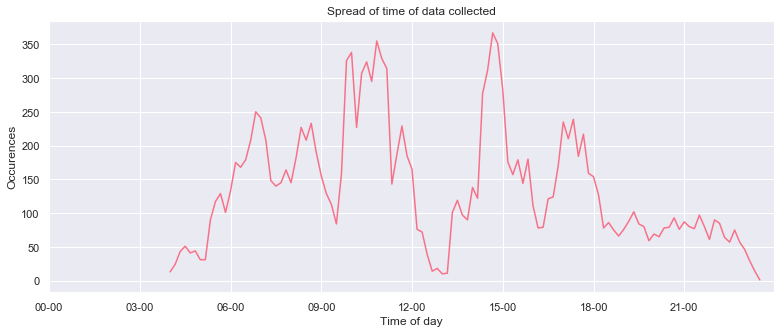

In [182]:
hour_min = [x[11:15] + '0' for x in data['expected_arrival']]
for_aggr = data.assign(hour_min = hour_min)
for_aggr = for_aggr.groupby('hour_min').count().reset_index()

arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(arrival_times, for_aggr['bus_stop_name'])
ax.set_title("Spread of time of data collected")
ax.set_xlim(dt.datetime.strptime('00:00', '%H:%M'), dt.datetime.strptime('23:59', '%H:%M'))
date_form = DateFormatter("%H-%M")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel("Time of day")
ax.set_ylabel("Occurences")
plt.show()

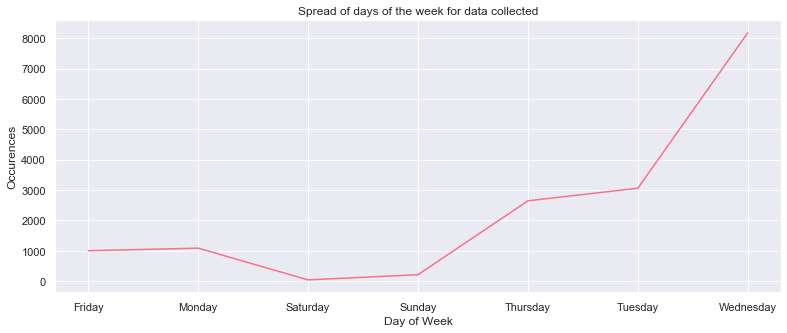

In [124]:
day_of_week = [x[:10] for x in data['expected_arrival']]
day_of_week = [dt.datetime.strptime(date, '%Y-%m-%d') for date in day_of_week]

day_of_week = [calendar.day_name[date.weekday()] for date in day_of_week]
for_aggr = data.assign(day_of_week = day_of_week)
for_aggr = for_aggr.groupby('day_of_week').count().reset_index()

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(for_aggr['day_of_week'], for_aggr['bus_stop_name'])
ax.set_title("Spread of days of the week for data collected")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Occurences")
plt.show()

### Try to see if I can get the average time taken for a bus to travel between "Vauxhall Bus Station" and "Battersea Park Station" (inbound)

In [133]:
vauxhall = data.loc[(data['bus_stop_name'] == 'Vauxhall Bus Station') & (data['direction'] == 'in')]
[_, vauxhall_id, _, _, _] = vauxhall.iloc[0]['vehicle_id'].split('_')
print(vauxhall.shape)
print(vauxhall_id)
vauxhall.head()

(178, 5)
490000247G1


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
32,Vauxhall Bus Station,2020-03-30 05:52:51,20191_490000247G1_2020-03-30_in_0,2020-03-30 05:28:43,in
50,Vauxhall Bus Station,2020-03-30 07:11:46,20310_490000247G1_2020-03-30_in_0,2020-03-30 06:43:43,in
196,Vauxhall Bus Station,2020-04-01 18:27:34,20271_490000247G1_2020-04-01_in_2,2020-04-01 18:27:13,in
198,Vauxhall Bus Station,2020-03-27 09:24:34,20194_490000247G1_2020-03-27_in_0,2020-03-27 09:03:54,in
343,Vauxhall Bus Station,2020-03-18 18:05:21,20193_490000247G1_2020-03-18_in_0,2020-03-18 18:05:12,in


In [177]:
battersea_prk_st = data.loc[(data['bus_stop_name'] == 'Battersea Park Station') & (data['direction'] == 'in')]
[_, battersea_prk_st_id, _, _, _] = battersea_prk_st.iloc[0]['vehicle_id'].split('_')
print(battersea_prk_st.shape)
print(battersea_prk_st_id)
battersea_prk_st.head()

(184, 5)
490G01016A


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
9,Battersea Park Station,2020-04-01 10:27:00,20271_490G01016A_2020-04-01_in_0,2020-04-01 10:26:42,in
24,Battersea Park Station,2020-04-01 09:53:39,20196_490G01016A_2020-04-01_in_0,2020-04-01 09:53:03,in
54,Battersea Park Station,2020-04-02 05:41:12,20193_490G01016A_2020-04-02_in_0,2020-04-02 05:34:44,in
56,Battersea Park Station,2020-03-03 14:43:14,20202_490G01016A_2020-03-03_in_0,2020-03-03 14:40:59,in
75,Battersea Park Station,2020-03-30 06:06:44,20203_490G01016A_2020-03-30_in_0,2020-03-30 06:06:41,in


In [169]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [179]:
journey_times = []

for i, journey in battersea_prk_st.iterrows():
    [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
    match_id = bus_id + '_' + vauxhall_id + '_' + date + '_' + direction + '_' + num_trip
    match = vauxhall.loc[vauxhall['vehicle_id'] == match_id]
    if match.size == 0:
        continue
    match = match.iloc[0]
    start = convert_time_to_datetime(journey['expected_arrival'])
    end = convert_time_to_datetime(match['expected_arrival'])
    diff = end - start
    journey_times.append(diff)

<class 'datetime.timedelta'>


TypeError: float() argument must be a string or a number, not 'datetime.timedelta'

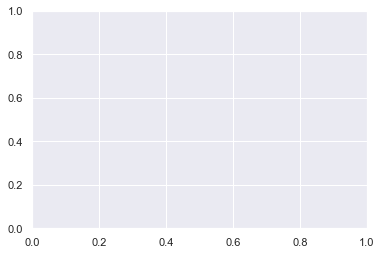

In [183]:
print(type(journey_times[0]))

fig, ax = plt.subplots()
ax.plot(journey_times, np.ones(len(journey_times)))
plt.show()